In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cleaning_fun as cfun
cle = cfun.cleaner()

%reload_ext autoreload
%autoreload 2

In [2]:
data1 = pd.read_csv("data1.csv")

# "abb14" () is droped due to their NaN values
data1.drop(["Unnamed: 0", "abb14"], axis = 1, inplace = True)
# Fill missing values in "last entrance" with subscription purchase date.
# This because all IDs that do not have a last entrance, actually never used the card (check below)
print(len(data1[data1["ultimo_ing.x"].isna()]))
data1["ultimo_ing.x"].fillna(data1["abb13"], inplace = True)

# Add a column that is the interval between last entrance date and subscription purchase date.
# It may be useful because this time window identifies those that can be really interested in museums
# (e.g. small span -> used the card immediately because of immediate purchase, then forgot about it)
data1["span.utilizzo"] = [x.days for x in pd.to_datetime(data1["ultimo_ing.x"]) - pd.to_datetime(data1["abb13"])]

# Convert the target variable to categorical
data1["si2014"] = pd.Categorical(data1["si2014"])
data1.head()

8090


,codcliente,si2014,ultimo_ing.x,abb13,span.utilizzo
0,100005,0,2013-09-19,2013-01-27,235
1,100006,1,2013-11-21,2013-01-14,311
2,100007,0,2012-12-05,2012-12-05,0
3,100017,1,2013-10-19,2012-12-10,313
4,100020,0,2013-08-11,2012-12-09,245


To check whether there were IDs who entered in a museum (`in13`) that had `NaN` values in the `data1["ultimo_ing.x"]` dataframe
```python
[x for x in in13cus["codcliente"].unique() if x in data1[data1["ultimo_ing.x"].isna()]["codcliente"].unique()]
```

-----------

In [3]:
an13 = pd.read_csv("an13.csv", na_values = "NA", encoding = "latin1")

# "CAP", "agenzia", "riduzione" & "sconto" have to many values to actually be useful.
# "Professione" has 100% NaN values
an13.drop(["Unnamed: 0", "professione", "sconto","riduzione", "agenzia", "cap"], axis = 1, inplace = True)

# Convert "data di nascita" into age at the end of year 2013.
# Before, it was necessary to replace 2 values that had "-" with
# the median of the overall year of birth distribution (= 1959).
median_age = pd.Series([x for x in an13["data_nascita"] if "-" not in x]).median()
an13["data_nascita"] = [int(x) if "-" not in x else int(median_age) for x in an13["data_nascita"]]
an13["age"] = an13["data_nascita"].apply(lambda x: 2013-x)

# "nuovo_abb" is alrady dichotomous and with full values. Just convert it into 0/1
an13["nuovo_abb"] = pd.Categorical(an13["nuovo_abb"].apply(lambda x: 1 if x == "NUOVO ABBONATO" else 0))

# "sesso" has missing values. We filled the according to the distribution of non-NaN values
count_sex = an13["sesso"].value_counts(normalize=True)
missing_sex = an13["sesso"].isnull()
an13.loc[an13["sesso"].isnull(),"sesso"] = np.random.choice(count_sex.index,
                                                            size = len(an13[missing_sex]),
                                                            p = count_sex.values)

# Then the 0/1 variable is created according to sex (female = 1)
an13["femmina"] = pd.Categorical(an13["sesso"].apply(lambda x: 1 if x == "F" else 0))

# Tipo_pag is converted into 4 dummies
an13 = pd.concat([an13, pd.get_dummies(an13["tipo_pag"], drop_first = True)], axis = 1)

# The following columns will then be converted into categories
an13["BANCOMAT"] = pd.Categorical(an13["BANCOMAT"])
an13["CONTANTI"] = pd.Categorical(an13["CONTANTI"])
an13["CARTA DI CREDITO"] = pd.Categorical(an13["CARTA DI CREDITO"])
an13["NESSUN PAGAMENTO"] = pd.Categorical(an13["NESSUN PAGAMENTO"])

an13.drop(["sesso","tipo_pag","data_nascita"], axis = 1, inplace = True)

In [4]:
# The following dataset, created from a .json file, is needed to
# reduce the dimensionality of the column "comune".
comunes = pd.read_csv("comuni_done.csv", sep = ";")
comunes.drop(["Unnamed: 0", "codice","zona__codice","zona__nome",
              "regione__codice","regione__nome","provincia__codice","provincia__nome",
              "codiceCatastale","CAP","popolazione"], axis = 1, inplace = True)
comunes["nome"] = comunes["nome"].str.upper()
comunes.rename({"nome": "comune"}, axis = 1, inplace = True)

# We performed a merge on the column "comune" of an13 dataframe,
# then we adjusted the result by creating a dictionary with the unmatched
# values of that column (mainly foregn countries).
an13 = an13.merge(comunes, how = "left", on = "comune")

# The following column is to replace NaN values of "sigla" according to the
# dictionary above, and eventually to reduce its dimensionality to 3
an13["sigla"] = cle.provs(an13)

# From the updated column "sigla" it was possible to create
# the dummies and attached them on the right side of an13.
an13 = pd.concat([an13, pd.get_dummies(an13["sigla"], drop_first = True)], axis = 1)
an13.drop(["comune","sigla"], axis = 1, inplace = True)

# Finally, the last column whose dimensionality needed a reduction was 
# "agenzia_tipo", that was broken down into 5 aspects based on conceptual
# clusters of the original values. Then the column is added to "an13" and dropped
an13["agenzia_tipo"] = cle.reduce_agency(an13)
an13 = pd.concat([an13, pd.get_dummies(an13["agenzia_tipo"], drop_first = True)], axis = 1)
an13.drop(["agenzia_tipo"], axis = 1, inplace = True)

# At last, we created the column of the day of the year
# in which a customer purchased their subscription.
an13["data_inizio"] = pd.to_datetime(an13["data_inizio"], format = "%d/%m/%Y %H:%M")
an13["day_y_purchase"] = [int(x.strftime('%j')) for x in an13["data_inizio"]]
an13.drop("data_inizio", axis = 1, inplace = True)

# Convert the dummies created into categorical variables
for c in an13.columns[9:15]:
    an13[c] = pd.Categorical(an13[c])

an13.head()

,codcliente,importo,nuovo_abb,age,femmina,BANCOMAT,CARTA DI CREDITO,CONTANTI,NESSUN PAGAMENTO,PI,TO,CRAL/TESSERE ORO/ASSOCIAZIONE,MUSEO/TEATRI/EDICOLE,OFFERTE/GRUPPI,PUNTO INFORMATIVO/COMMERCIALE/NAN,day_y_purchase
0,90095,28,1,28,0,0,0,1,0,0,1,0,0,0,1,344
1,89662,28,1,28,0,0,0,1,0,0,1,0,0,0,1,6
2,202278,28,1,21,0,1,0,0,0,0,1,0,0,0,1,27
3,269895,28,1,27,0,0,0,1,0,0,0,0,0,0,1,337
4,88177,28,1,30,0,0,0,1,0,0,1,0,0,0,1,26


------------------

In [5]:
in13 = pd.read_csv("in13.csv", na_values = "NA")
in13.drop("Unnamed: 0", axis = 1, inplace = True)
# The rename will be useful in the merge of the 3 final datasets,
# while the following line is a quick string cleaning
in13.rename({"CodCliente": "codcliente"}, axis = 1, inplace = True)
in13["museo"] = [x.replace("\\","").replace('"',"") for x in in13["museo"]]

# Merge with a file that contains the type of museum per each line
un_mus = pd.read_excel("museums.xlsx")
un_mus["museo"] = [x.replace("\\","").replace('"',"") for x in un_mus["museo"]]
in13 = in13.merge(un_mus, how = "left", on = "museo")
in13.drop(["comune.museo","prov.museo"], axis = 1, inplace = True)

# Drop (actually exclude) all the rows that contain the weird "00:00" value
in13 = in13[in13['orai'] != "00:00"]

# Collapse into one column the date and time of entrance, so the timestamp is precise and unique
in13["timestamp"] = pd.to_datetime(in13["datai"] + " " + in13["orai"], format = "%d/%m/%Y %H:%M")

# Drop "day_entrance" & "time_entrance"
in13.drop(["datai", "orai"], axis = 1, inplace = True)

# Order the dataset by the timestamp
in13.sort_values(by = ["timestamp"], inplace = True)
in13.reset_index(drop = True, inplace = True)

In [6]:
# Apply the function in the class
in13 = cle.company(in13)
in13.head()

C:\Users\matti\Desktop\BA Year 3\1. Business analytics\4. Project\cleaning_fun.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["min_delta"] = [float(x.total_seconds()/60) for x in data['timestamp'].diff(periods = 1)]
C:\Users\matti\Desktop\BA Year 3\1. Business analytics\4. Project\cleaning_fun.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["min_delta"][0] = data["min_delta"][1]
C:\Users\matti\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,importo,museo,prov_museo,com_museo,codcliente,tipo.museo,timestamp,compagnia
0,7.5,REGGIA DI VENARIA REALE,TO,VENARIA REALE,46715,Storia,2012-12-01 10:10:00,1
1,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,46715,Storia,2012-12-01 10:11:00,1
2,7.5,REGGIA DI VENARIA REALE,TO,VENARIA REALE,133015,Storia,2012-12-01 10:11:00,1
3,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,133015,Storia,2012-12-01 10:12:00,1
4,5.0,REGGIA DI VENARIA REALE,TO,VENARIA REALE,16834,Storia,2012-12-01 10:39:00,0


In [7]:
# From "in13", we've built a new dataframe with the following columns:
# - codcliente
# - frequenza: number of times every customer went to museums
# - variety: how many different museums they have visited
# - tipo.passione: the kind of museum in which each customer is more fond of
# - passione.score: given different museum's categories, this score measures how many times a customer
#                   prefers a category. If they did only one visit, the score is set just below the 0.8 thershold
# - appassionato: takes the "passione" scores into a dichotomous variable at a 0.8 threshold.
#                 The result is that only 20% of the customer is defined as passionate, which may be closed to reality
# - compagnia: takes the average of the values in in13, then at a 0.5 threshold, the variable is converted to dichotomous

IDs = np.array(pd.DataFrame(in13["codcliente"].value_counts()).index)

in13cus = pd.DataFrame({"codcliente":IDs,
                            "frequenza":pd.DataFrame(in13["codcliente"].value_counts())["codcliente"]})

in13cus["variety"] = [ len(in13[in13["codcliente"] == x]["museo"].unique()) for x in IDs ]

in13cus["tipo.passione"] = [list(dict(in13[in13["codcliente"] == x]["tipo.museo"].value_counts()).keys())[0]
                            for x in IDs]

in13cus["passione.score"] = [(in13[in13["codcliente"] == x]["tipo.museo"].value_counts()[0])/(in13cus.loc[x]["frequenza"])
                             for x in IDs ]

in13cus["passione.score"] = [in13cus.loc[x]["passione.score"] if in13cus.loc[x]["frequenza"] > 1 else 0.79
                             for x in IDs ]

in13cus.reset_index(inplace = True, drop = True)

# Luogo di culto -> arte
# Castello -> storia
in13cus["appassionato"] = ["Non.appassionato" if in13cus.loc[n]["passione.score"] < 0.8
                           else in13cus.loc[n]["tipo.passione"] for n in range(len(in13cus))]


in13cus["compagnia"] = [in13[in13["codcliente"] == x]["compagnia"].mean() for x in IDs]
in13cus["compagnia"] = pd.Categorical( in13cus["compagnia"].apply(lambda x: 1 if x > 0.5 else 0) )

in13cus = pd.concat([in13cus, pd.get_dummies(in13cus["appassionato"], drop_first = True)], axis = 1)
in13cus.drop(["appassionato","tipo.passione","passione.score"], axis = 1, inplace = True)

for c in in13cus.columns[4:]:
    in13cus[c] = pd.Categorical(in13cus[c])

in13cus.head()

,codcliente,frequenza,variety,compagnia,Arte,Non.appassionato,Parco,Scienze,Sport,Storia
0,219314,254,63,0,0,1,0,0,0,0
1,48954,172,75,0,0,1,0,0,0,0
2,185108,121,29,0,0,1,0,0,0,0
3,172643,100,19,0,0,1,0,0,0,0
4,194104,94,10,0,0,1,0,0,0,0


-------------

In [8]:
print(data1.shape, an13.shape, in13cus.shape)

(80140, 5) (87072, 16) (77648, 10)


In [13]:
df0 = in13cus.merge(an13, on = "codcliente")
df = df0.merge(data1, on = "codcliente")
df.shape

(71504, 29)

In [14]:
print(round(len(data1[data1["si2014"] == 1])/len(data1)*100,2),"%")
print(round(len(df[df["si2014"] == 1])/len(df)*100,2),"%")

69.39 %
72.26 %


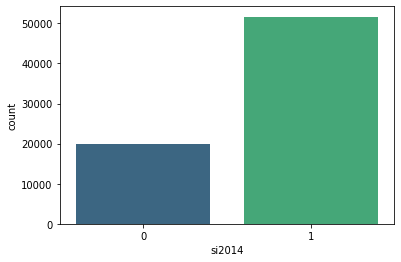

In [15]:
sns.countplot(df["si2014"], palette = "viridis")

In [18]:
df

,codcliente,frequenza,variety,compagnia,Arte,Non.appassionato,Parco,Scienze,Sport,Storia,...,TO,CRAL/TESSERE ORO/ASSOCIAZIONE,MUSEO/TEATRI/EDICOLE,OFFERTE/GRUPPI,PUNTO INFORMATIVO/COMMERCIALE/NAN,day_y_purchase,si2014,ultimo_ing.x,abb13,span.utilizzo
0,219314,254,63,0,0,1,0,0,0,0,...,1,0,0,0,1,337,1,2013-11-29,2012-12-02,362
1,48954,172,75,0,0,1,0,0,0,0,...,1,0,0,1,0,345,1,2013-11-30,2012-12-10,355
2,185108,121,29,0,0,1,0,0,0,0,...,1,0,1,0,0,26,1,2013-12-30,2013-01-26,338
3,172643,100,19,0,0,1,0,0,0,0,...,1,0,0,0,1,8,1,2014-01-06,2013-01-08,363
4,194104,94,10,0,0,1,0,0,0,0,...,1,0,1,0,0,365,1,2013-12-26,2012-12-30,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71499,29285,1,1,1,0,1,0,0,0,0,...,1,0,1,0,0,57,1,2014-01-26,2013-02-26,334
71500,76366,1,1,1,0,1,0,0,0,0,...,1,0,0,0,1,53,1,2014-02-05,2013-02-22,348
71501,218582,1,1,1,0,1,0,0,0,0,...,1,0,0,0,1,39,1,2013-08-17,2013-02-08,190
71502,202206,1,1,1,0,1,0,0,0,0,...,1,0,0,0,1,366,1,2013-12-29,2012-12-31,363


In [12]:
#df.to_csv("FINAL_DF.csv")